Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as any collaborators you worked with:

In [1]:
COLLABORATORS = ""

---

In [18]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# HW 6:  ODE Methods - Boundary Value Problems

This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems

This problem set has two questions

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [4] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

YOUR ANSWER HERE

Let $u(x) = A\sin(3x) + B\sin(x) + C\cos(x)$
$$ u^{\prime\prime}+ u = \sin3x$$
$$u(x) = A\sin(3x)$$
$$u^{\prime} = 3A\sin(3x)$$
$$u^{\prime\prime} = -9A\sin(3x)$$
$$-9A\sin(3x) + A\sin(3x) = \sin(3x)$$
$$A = \frac{-1}{8}$$

$$u(x) = -\frac{1}{8}\sin(3x) + B\sin(x) + C\cos(x)$$

$$u(0) = 0, C = 0$$

$$u(L) = 0, B = \frac{\sin(3L)}{8\sin(L)}$$

$$u(x) = -\frac{1}{8}\sin(3x) + \frac{\sin(3L)}{8\sin(L)}\sin(x)$$

* The solution is unique because there is no undertermined coefficients or constant in the ODE solution.

**(b)** [2]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

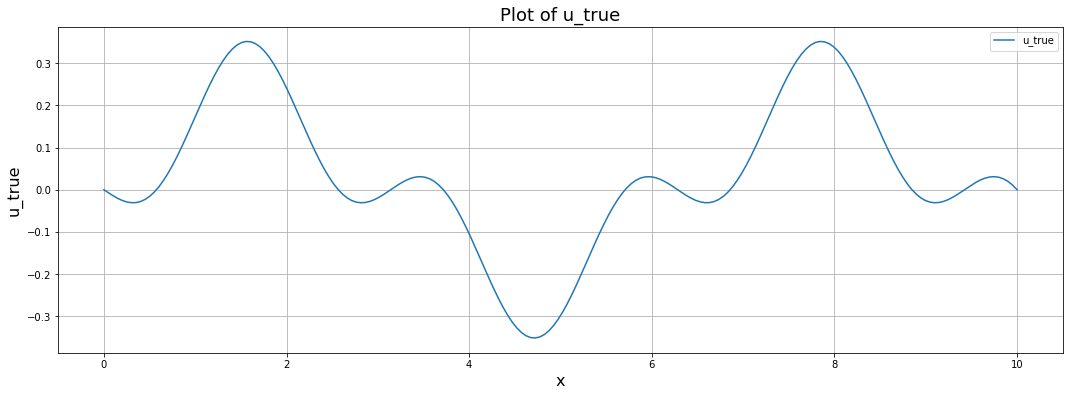

In [19]:
L = 10.
A = numpy.sin(3*L)/(8*numpy.sin(L))
# YOUR CODE HERE
u_true = lambda x: (A*numpy.sin(x) - numpy.sin(3*x)/8)
N = 200
x = numpy.linspace(0., L, N)
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, u_true(x),label='u_true')
axes.set_title("Plot of u_true", fontsize=18)
axes.set_xlabel("x", fontsize=16)
axes.set_ylabel("u_true", fontsize=16)
axes.legend()
axes.grid()

**(b)** [4] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

In [20]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, fsolve
a = 0.0
b = 10.
N = 100
u_a = 0.0
u_b = 0.0
i_a = 0
i_b = 0
x = numpy.linspace(a, b, N)
TOLERANCE = 1e-8
MAX_ITERATIONS = 100
u_prime_rhs = -1.0
du_prime = 0.5
success = False

def objective(u_prime_rhs):
    sol = solve_ivp(f, [a, b], \
            [u_a, u_prime_rhs], dense_output=True, t_eval=x)
    u = sol.y[0]f
    return sol.y[0, -1] - u_b

def f(x, u):
    return numpy.array([u[1], -u[0] + numpy.sin(3*x)])

# Plotting
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)

# Main loop
success = False
u = numpy.empty((2, N))
u0 = numpy.empty(2)
convergence = numpy.zeros(MAX_ITERATIONS)
low = -10
high = 10
for n in range(MAX_ITERATIONS):
    
    # Initial condition
    uprime0 = numpy.mean([low, high])
    u0 = [u_a, uprime0]
    # Compute solution - note that we are only producing the intermediate values
    # for demonstration purposes
    
    sol = solve_ivp(f, [a, b], u0, dense_output=True, t_eval=x)
    u_end = sol.y[0,-1]
    y_num = sol.y[0, :]
    # Stopping Criteria 
    # this should really be a bracketing scheme
    convergence[n] = numpy.abs(u_end - u_b)
    if convergence[n] < TOLERANCE:
        success = True
        break
    else:
        if u_end < 0:
            high = uprime0
        else:
            low = uprime0

    axes.plot(x, sol.sol(x)[0], 'b')
    axes.plot(b, u_b, 'ro')

axes.set_title("Shooting Method Iterations")
axes.set_xlabel("$x$")
axes.set_ylabel("$u(x)$")
axes.grid()

axes = fig.add_subplot(1, 2, 2)
n_range = numpy.arange(n)
axes.semilogy(n_range, convergence[:n])
axes.set_title("Convergence of Shooting Method")
axes.set_xlabel("step")
axes.set_ylabel("$|u(b) - U(b)|$")
axes.grid()

plt.show()

SyntaxError: invalid syntax (<ipython-input-20-a86450b00faa>, line 20)

In [21]:
#  write a general shooting algorithm

from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):
    """
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
        
    parameters:
    -----------
    f: calleable 
        vector value function for righthand side of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known  
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known  
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance
        
    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """
    # YOUR CODE HERE
    MAX_ITERATIONS = 100
    u_prime_rhs = u_a[1 - i_a]
    success = False
    low = -10
    high = 10
    a = x[0]
    b = x[-1]
    x_eval = numpy.linspace(x[0], x[-1], MAX_ITERATIONS)
    F = lambda u_prime: solve_ivp(f, [a, b], [u_a[i_a], u_prime], 
                                  dense_output=True, t_eval=x, rtol=rtol, atol=atol).y[i_b,-1] - u_b[i_b]
    
    for n in range(MAX_ITERATIONS):
        u0 = [u_a[i_a], u_prime_rhs]
        sol = solve_ivp(f, [a, b], u0, dense_output=True, rtol=rtol, atol=atol, t_eval=x)
        u_end = sol.y[i_b,-1]
        convergence = numpy.abs(u_end - u_b[i_b])
        if convergence < atol:
            success = True
            break
        else:
            root = root_scalar(F, bracket=[low, high], method='brentq')
            u_prime_rhs = root.root
            print('u_prime: ', u_prime_rhs)
    return sol.sol(x)[0]

def shoot_bvp1(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):
    """
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
        
    parameters:
    -----------
    f: calleable 
        vector value function for righthand side of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known  
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known  
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance
        
    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """
    # YOUR CODE HERE
    MAX_ITERATIONS = 100
    u_prime_rhs = u_a[1 - i_a]
    success = False
    low = -10
    high = 10
    a = x[0]
    b = x[-1]
    x_eval = numpy.linspace(x[0], x[-1], MAX_ITERATIONS)
    F = lambda u_prime: solve_ivp(f, [a, b], [u_a[i_a], u_prime], 
                                  dense_output=True, t_eval=x, rtol=rtol, atol=atol).y[i_b,-1] - u_b[i_b]
    
    for n in range(MAX_ITERATIONS):
        u0 = [u_a[i_a], u_prime_rhs]
        sol = solve_ivp(f, [a, b], u0, dense_output=True, rtol=rtol, atol=atol, t_eval=x)
        u_end = sol.y[i_b,-1]
        convergence = numpy.abs(u_end - u_b[i_b])
        if convergence < atol:
            success = True
            break
        else:
            root = root_scalar(F, bracket=[low, high], method='brentq')
            u_prime_rhs = root.root
            print('u_prime: ', u_prime_rhs)
    return sol.y[0]
    
def shoot_bvp2(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):
    success = False
    u = numpy.empty((2, N))
    u0 = numpy.empty(2)
    convergence = numpy.zeros(MAX_ITERATIONS)
    low = -10
    high = 10
    for n in range(MAX_ITERATIONS):
        # Initial condition
        uprime0 = numpy.mean([low, high])
        u0 = [u_a, uprime0]
        # Compute solution - note that we are only producing the intermediate values
        # for demonstration purposes
    
        sol = solve_ivp(f, [a, b], u0, dense_output=True, t_eval=x, rtol=rtol, atol=atol)
        u_end = sol.y[0,-1]
        y_num = sol.y[0, :]
        # Stopping Criteria 
        # this should really be a bracketing scheme
        convergence[n] = numpy.abs(u_end - u_b)
        if convergence[n] < TOLERANCE:
            success = True
            break
        else:
            if u_end < 0:
                high = uprime0
            else:
                low = uprime0
    return sol.sol(x)[0]


**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

u_prime:  -0.14797947017169683
3.9407309305431696e-08


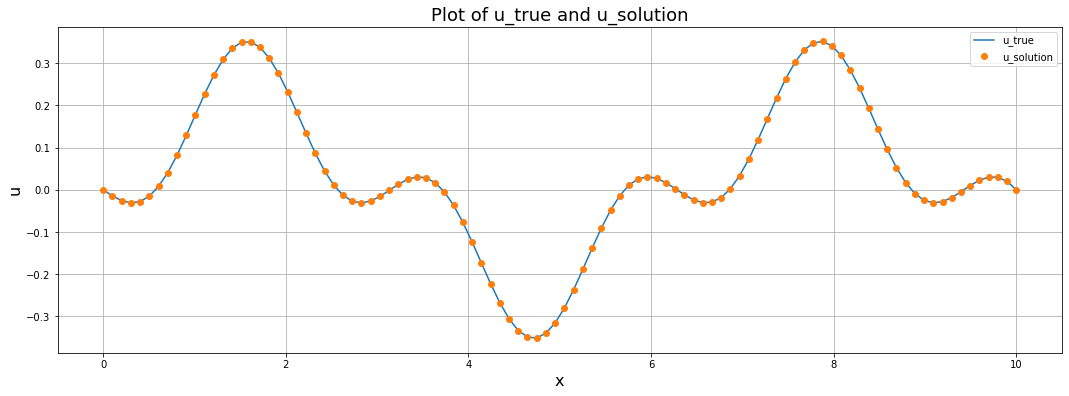

In [22]:
# YOUR CODE HERE
a = 0.0
L = 10.
N = 100
u_a = [0.0, 1]
u_b = [0.0, 0]
i_a = 0
i_b = 0
def f(x, u):
    return numpy.array([u[1], -u[0] + numpy.sin(3*x)])
x = numpy.linspace(a, L, N)
u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-7, atol=1.e-9)
A = numpy.sin(3*L)/(8*numpy.sin(L))
u_true = lambda x, L: (numpy.sin(3*L)/(8*numpy.sin(L))*numpy.sin(x) - numpy.sin(3*x)/8)
print(numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L)))

fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, u_true(x, L),label='u_true')
axes.plot(x, u_sol,'o',label='u_solution')
axes.set_title("Plot of u_true and u_solution", fontsize=18)
axes.set_xlabel("x", fontsize=16)
axes.set_ylabel("u", fontsize=16)
axes.legend()
axes.grid()

The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [23]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

relative error = 3.9407309305431696e-08
success


**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

In [24]:
# routines from class  for generating 2nd order sparse second derivative operator and RHS vector

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs
    

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

/opt/conda/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


,Grid points 𝑁,Relative Error,Grid spacing Δ𝑥
0,8,1.552160e+01,1.428571
1,16,3.027761e-01,0.666667
2,32,5.613787e-02,0.322581
3,64,1.293193e-02,0.158730
4,128,3.145100e-03,0.078740
5,256,7.778857e-04,0.039216
6,512,1.935736e-04,0.019569
7,1024,4.829031e-05,0.009775
8,2048,1.206025e-05,0.004885
9,4096,3.013558e-06,0.002442


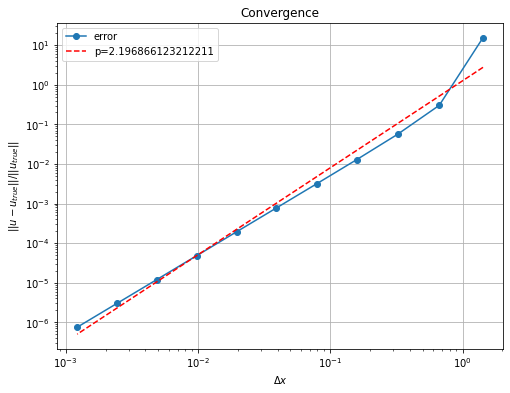

In [25]:
# Make a well labeled convergence plot that shows  convergence rate of relative error vs grid spacing
from scipy.sparse.linalg import spsolve
import pandas
# YOUR CODE HERE
N = 100
a = 0.
b = 10.
u_true = lambda x, L: (numpy.sin(3*L)/(8*numpy.sin(L))*numpy.sin(x) - numpy.sin(3*x)/8)
N = [ 2**n for n in range (3, 14)]
rel_err = numpy.empty(len(N))
delta_x = numpy.empty(len(N))
# fig = plt.figure(figsize=(10, 8))
# axes = fig.add_subplot(1, 1, 1)
f_x = lambda x: numpy.sin(3*x)
data = []
for (i, n) in enumerate(N):
    x = numpy.linspace(a, b, n)
    delta_x[i] = x[1] - x[0]
    I_padded = numpy.identity(n)
    I_padded[0,0] = 0
    I_padded[-1,-1] = 0
    A = D2(x,['dirichlet','dirichlet']) + I_padded
    f = RHS(x, f_x, [0., 0. ])
    u_sol = spsolve(A, f)
    utrue = u_true(x,b)
    rel_err[i] = numpy.linalg.norm(u_sol - utrue)/numpy.linalg.norm(utrue)
    data.append([n, rel_err[i], delta_x[i]])

p = numpy.polyfit(numpy.log(delta_x),numpy.log(rel_err),1)
dx = numpy.logspace(numpy.log10(delta_x[0]),numpy.log10(delta_x[-1]),100)
err = numpy.exp(p[1])*dx**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, rel_err, 'o-',label='error')
axes.loglog(dx,err,'r--',label="p={}".format(p[0]))
axes.set_title("Convergence")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$||u - u_{true}||/||u_{true}||$")
axes.legend(loc='best')
axes.grid()

error_table = pandas.DataFrame(data, columns=['Grid points  𝑁', 'Relative Error', 'Grid spacing  Δ𝑥'])
display(error_table)



In [26]:
print('p: {}, C: {}, log C: {}'.format(p[0], numpy.exp(p[1]), p[1]))

p: 2.196866123212211, C: 1.2619124340681889, log C: 0.23262837507789275


ANSWER HERE:

* rate of convergence of error ( $p$ such that $e_{rel}\propto \Delta x^p$) $p = 2.196866117356639 \approx 2$
* number of grid points $N = 8192$ required for the relative error to be $\leq 10^{-6}$ 
* the relative error is 7.532036e-07 at this smallest mesh spacing $\Delta x = 0.001221$

### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Question 2 - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [27]:
# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = x0 
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return x, k
        delta = spsolve(J(x),-F(x))
        x += delta
    
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

k = 0, ||F|| = 9.975647311061401
k = 1, ||F|| = 0.04006687183388152
k = 2, ||F|| = 0.0011390847101260331
k = 3, ||F|| = 1.5434914479094596e-06
k = 4, ||F|| = 3.000399725070823e-12


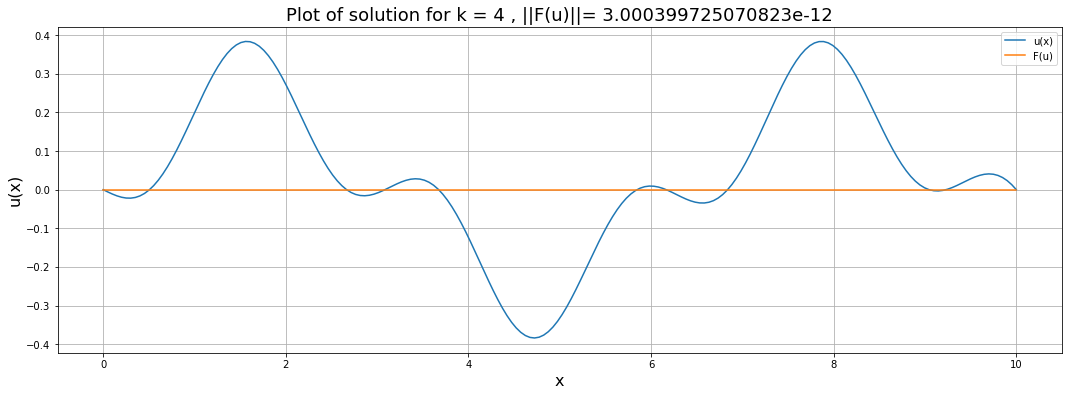

In [28]:
# YOUR CODE HERE
L =10
N = 200
x = numpy.linspace(0.,L,N)
A = D2(x)
# set the residual with 0 dirichlet condtions
def F(u):
    f =  A.dot(u) + numpy.sin(u) - numpy.sin(3*x)
    # set residual to 0 on dirichlet BCs
    f[[0,-1]] = 0
    return f

# set the jacobian
def J(u):
    n = len(u)
    return A + spdiags(numpy.cos(u),0,n,n)
    

# initial guess use a straight line with the correct boundary conditions

u0 = numpy.linspace(0.,0,N)
sol,its = newton(F,J,u0)
norm = numpy.linalg.norm(F(sol))

N = 200
fig = plt.figure(figsize=(18,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, sol, label='u(x)')
axes.plot(x, F(sol), label='F(u)')
axes.set_title("Plot of solution for k = {} , ||F(u)||= {}".format(its, norm), fontsize=18)
axes.set_xlabel("x", fontsize=16)
axes.set_ylabel("u(x)", fontsize=16)
axes.legend()
axes.grid()

ANSWER HERE:

k = 4, ||F|| = 3.000399725070823e-12

**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

n: 0
k = 0, ||F|| = 9.975647311061401
k = 1, ||F|| = 0.04006687183388152
k = 2, ||F|| = 0.0011390847101260331
k = 3, ||F|| = 1.5434914479094596e-06
k = 4, ||F|| = 3.000399725070823e-12
n: 1
k = 0, ||F|| = 12.615463299668624
k = 1, ||F|| = 2.0439586299424257
k = 2, ||F|| = 0.18654333489521654
k = 3, ||F|| = 0.006611195165857748
k = 4, ||F|| = 1.625078713813772e-05
k = 5, ||F|| = 1.0933252020427013e-10
n: 2
k = 0, ||F|| = 11.178671459419448
k = 1, ||F|| = 4.711169206133468
k = 2, ||F|| = 2.4375073125281683
k = 3, ||F|| = 0.44030686394512164
k = 4, ||F|| = 0.04454324025199275
k = 5, ||F|| = 0.0007078169660289525
k = 6, ||F|| = 2.114481499129786e-07
n: 3
k = 0, ||F|| = 9.766727086672523
k = 1, ||F|| = 0.14770565274937952
k = 2, ||F|| = 0.014730589706813626
k = 3, ||F|| = 0.0003911784528408722
k = 4, ||F|| = 3.2253756636996376e-07
n: 4
k = 0, ||F|| = 11.934795789806302
k = 1, ||F|| = 1.516007559300804
k = 2, ||F|| = 0.29329452926831456
k = 3, ||F|| = 0.046693551496180576
k = 4, ||F|| = 0.00

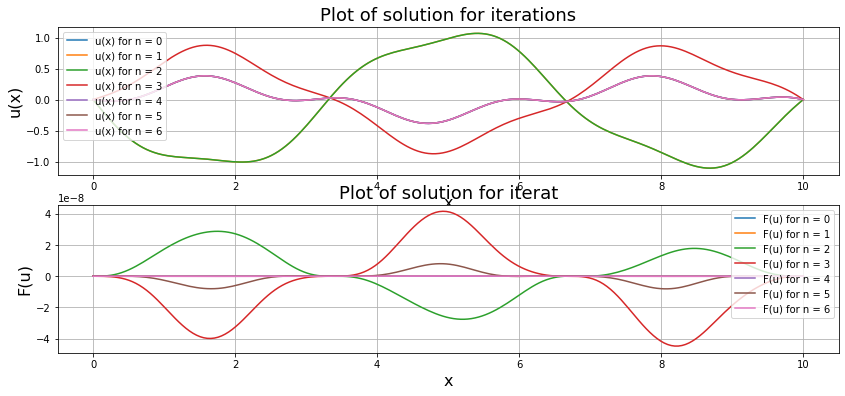

In [29]:
# YOUR CODE HERE
L = 10
N = 200
u0_x = lambda x: numpy.sin((n*numpy.pi*x)/L)
x = numpy.linspace(0.,L,N)
fig = plt.figure(figsize=(14,6))
axes = fig.add_subplot(2, 1, 1)
axes1 = fig.add_subplot(2, 1, 2)
for n in range(7):
    u0 = u0_x(x)
    print('n:', n)
    sol,its = newton(F,J,u0, verbose=True)
    axes.plot(x, sol,label='u(x) for n = {}'.format(n))
    axes1.plot(x, F(sol),label='F(u) for n = {}'.format(n))
axes.set_title("Plot of solution for iterations", fontsize=18)
axes.set_xlabel("x", fontsize=16)
axes.set_ylabel("u(x)", fontsize=16)
axes.legend()
axes.grid()

axes1.set_title("Plot of solution for iterat", fontsize=18)
axes1.set_xlabel("x", fontsize=16)
axes1.set_ylabel("F(u)", fontsize=16)
axes1.legend()
axes1.grid()

ANSWER HERE:

1. The above solution is not unique.
2. There are 3 different solution.
3. The residual $𝐅(𝐮)$ is least when n= 0, $|𝐅(𝐮)| = 3.000399725070823e-12$ and n= 4, $|𝐅(𝐮)| = 2.6884386457661288e-11$.


### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?